<a href="https://colab.research.google.com/github/caxiano/machine-learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras
import tensorflow as tf

from keras.applications.imagenet_utils import preprocess_input

In [20]:
# downloading data
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = keras.utils.get_file(
    'cats_and_dogs.zip', origin=URL, extract=True
)


# loading data
data_path = os.path.join(
    os.path.dirname(path_to_zip), 'cats_and_dogs_extracted', 'cats_and_dogs_filtered'
)

train_dir = os.path.join(data_path, 'train')
validation_dir = os.path.join(data_path, 'validation')


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)
validation_dataset = keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [21]:
# separando uma parte dos dados de validação para teste
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


# pegando modelo base
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


base_model.trainable = False


data_argumentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [22]:


# criando a estrutura do modelo principal incluindo o modelo base
inp = tf.keras.Input(shape=(160, 160, 3))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_argumentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
# compilando modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


loss0, accuracy0 = model.evaluate(validation_dataset)

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 703ms/step - accuracy: 0.5106 - loss: 1.1759
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4933 - loss: 1.0822 - val_accuracy: 0.5074 - val_loss: 0.7817
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4932 - loss: 0.8219 - val_accuracy: 0.5371 - val_loss: 0.7338
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5153 - loss: 0.8033 - val_accuracy: 0.5532 - val_loss: 0.6984
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5408 - loss: 0.7661 - val_accuracy: 0.5866 - val_loss: 0.6713
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5658 - loss: 0.7268 - val_accuracy: 0.6015 - val_loss: 0.6422
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5585 - loss: 0.7329 - val_accuracy: 0.6126 - val_loss: 0.6270
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5841 - loss: 0.7106 - val_accuracy: 0.6238 - val_loss: 0.6089
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 

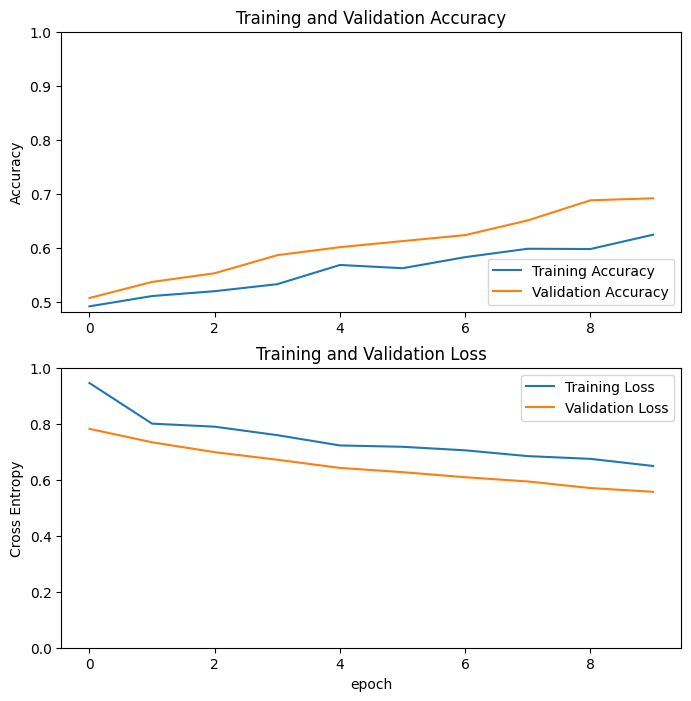

In [24]:
# visualizando os resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [25]:
model.evaluate(test_dataset)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.6783 - loss: 0.5548


[0.5616082549095154, 0.6666666865348816]